In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

%matplotlib inline

## Datasets

In [2]:
ratings = pd.read_csv("ratings.csv", sep=",", encoding="utf-8", quotechar='"')
ratings["timestamp"].apply(pd.to_numeric)
ratings["Datetime"] = ratings["timestamp"].apply(dt.fromtimestamp)
ratings.rename({"timestamp": "rating_timestamp", "Datetime": "rating_datetime"}, axis=1, inplace=True)

In [3]:
movies = pd.read_csv("movies.csv", sep=",", encoding="utf-8", quotechar='"')

In [4]:
tags = pd.read_csv("tags.csv", sep=",", encoding="utf-8", quotechar='"')
tags["timestamp"].apply(pd.to_numeric)
tags["Datetime"] = tags["timestamp"].apply(dt.fromtimestamp)
tags.rename({"timestamp": "tag_timestamp", "Datetime": "tag_datetime"}, axis=1, inplace=True)

## User-oriented approach

In [5]:
user_avg_rating = ratings.groupby("userId").mean(numeric_only=True)["rating"]
user_count_of_ratings = ratings.groupby("userId").count()["movieId"]

In [6]:
users_df = pd.DataFrame(user_count_of_ratings)

In [7]:
users_df.rename({"movieId": "ratings_count"}, axis=1, inplace=True)
users_df = pd.merge(left=users_df, right=user_avg_rating, on="userId")
users_df.rename({"rating": "avg_rating"}, axis=1, inplace=True)

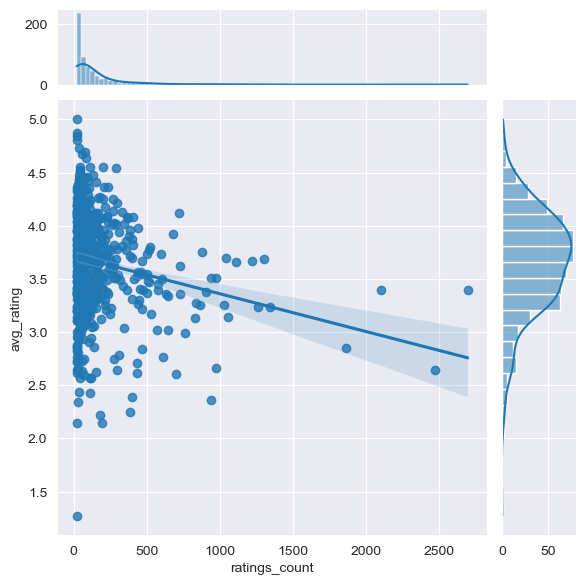

In [8]:
sns.set_style("darkgrid")
sns.jointplot(x="ratings_count", y="avg_rating", data=users_df, kind="reg", marginal_ticks=True)

From this plot the only two points are the two marginal plots in which we can make oseravtions about the distribution of those two variables.
Moreover from the scatterplot the only thing that matters most is that users who watched more than 1000 movies are very few. The vast majority of users has watched from 0 to 500 movies

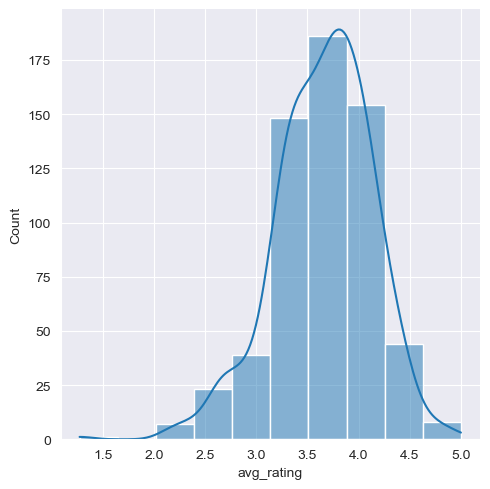

In [9]:
sns.displot(users_df["avg_rating"], kde=True, bins=10)

## Movie-oriented approach

In [10]:
print("Number of distinct movies: ", len(movies))
print("Number of distinct users who have rated the movies: ", ratings["userId"].nunique())
print("Number of total ratings: ", len(ratings))

Number of distinct movies:  9742
Number of distinct users who have rated the movies:  610
Number of total ratings:  100836


In [11]:
def custom_sort(value):
    new_value = sorted(value.split("|"))
    text = "|".join(new_value)
    return text


movies["genres"] = movies["genres"].apply(custom_sort)

print("Number of unique combinations of genres: ", movies["genres"].nunique())

Number of unique combinations of genres:  951


There are to many combinations of genres to create dummies variables, so a better approach is to classify movies into the unique genres. Note that the a movie can be classified into more than one unique genre.

In [12]:
movies_per_user = {user: [] for user in ratings["userId"]}
users_per_movie = {movie: [] for movie in ratings["movieId"]}

for i, row in ratings.iterrows():
    movies_per_user[row["userId"]].append(row["movieId"])
    users_per_movie[row["movieId"]].append(row["userId"])
assert len(movies_per_user[1]) == len(ratings[ratings["userId"] == 1])
assert len(users_per_movie[1]) == len(ratings[ratings["movieId"] == 1])

In [13]:
# Find the unique genres(not combinations of genres)
genres_combinations = []
for element in movies["genres"].unique():
    genres_combinations.append(element.split("|"))

# Create dummies variables for each genre
unique_genres = []
for combination in genres_combinations:
    for genre in combination:
        if genre not in unique_genres:
            unique_genres.append(genre)

for genre in unique_genres:
    movies[genre] = 0


def fill_genre_columns(row):
    genres = row["genres"].split("|")
    for genre in genres:
        row[genre] = 1
    return row


movies = movies.apply(fill_genre_columns, axis=1)

In [14]:
# Drop the genres and keeponly the dummies
movies.drop("genres", axis=1, inplace=True)

In [15]:
# Find out how many movies each category has
movies_per_genre = {genre: movies[movies[genre] == 1]["title"].nunique() for genre in unique_genres}
movies_per_genre = pd.Series(movies_per_genre).sort_values(ascending=False)

In [16]:
movies_per_genre

Drama                 4359
Comedy                3755
Thriller              1892
Action                1827
Romance               1595
Adventure             1263
Crime                 1198
Sci-Fi                 978
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Action'),
  Text(4, 0, 'Romance'),
  Text(5, 0, 'Adventure'),
  Text(6, 0, 'Crime'),
  Text(7, 0, 'Sci-Fi'),
  Text(8, 0, 'Horror'),
  Text(9, 0, 'Fantasy'),
  Text(10, 0, 'Children'),
  Text(11, 0, 'Animation'),
  Text(12, 0, 'Mystery'),
  Text(13, 0, 'Documentary'),
  Text(14, 0, 'War'),
  Text(15, 0, 'Musical'),
  Text(16, 0, 'Western'),
  Text(17, 0, 'IMAX'),
  Text(18, 0, 'Film-Noir'),
  Text(19, 0, '(no genres listed)')])

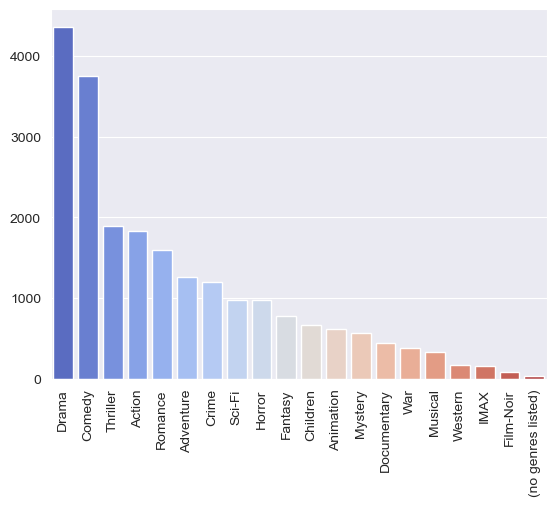

In [17]:
sns.barplot(x=movies_per_genre.keys().tolist(), y=movies_per_genre.values.tolist(), palette="coolwarm")
plt.xticks(rotation="vertical")

## A more holistic approach combining user's ratings and movies

In [18]:
# Combines the rating data with the movies data on movieId
df = pd.merge(left=ratings, right=movies, how="inner", on="movieId")

In [19]:
# How many movies each user has watched.
count_of_movies_per_user = ratings.groupby("userId").count()
count_of_movies_per_user.reset_index(inplace=True)
count_of_movies_per_user = count_of_movies_per_user[["userId", "movieId"]]
count_of_movies_per_user.rename({"movieId": "num_of_movies"}, axis=1, inplace=True)

In [20]:
# Concatenate ratings with how many movies each user has watched and the specific info for each movie
ratings = pd.merge(left=ratings, right=count_of_movies_per_user, on="userId", how="inner")
ratings = pd.merge(left=ratings, right=movies, on="movieId")

In [21]:
# How many movies per genre each user has watched
movies_per_genre_and_user = ratings.groupby("userId").sum(numeric_only=True)
# Keep only the columns about the userId and unique genres
unique_genres.append("userId")
movies_per_genre_and_user.reset_index(inplace=True)
movies_per_genre_and_user = movies_per_genre_and_user[unique_genres]
unique_genres.pop(-1)

'userId'

In [22]:
# Drop the duplicate columns that where created on merging
movies_per_genre_and_user = pd.merge(left=ratings, right=movies_per_genre_and_user, on="userId")

movies_per_genre_and_user.drop(
    [
        "Adventure_x",
        "Animation_x",
        "Children_x",
        "Comedy_x",
        "Fantasy_x",
        "Romance_x",
        "Drama_x",
        "Action_x",
        "Crime_x",
        "Thriller_x",
        "Horror_x",
        "Mystery_x",
        "Sci-Fi_x",
        "War_x",
        "Musical_x",
        "Documentary_x",
        "IMAX_x",
        "Western_x",
        "Film-Noir_x",
        "(no genres listed)_x",
        "rating",
        "rating_timestamp",
        "rating_datetime",
        "title",
        "movieId",
    ],
    axis=1,
    inplace=True,
)

# Rename them to the original columns names
movies_per_genre_and_user.rename(
    {
        "Adventure_y": "Adventure",
        "Animation_y": "Animation",
        "Children_y": "Children",
        "Comedy_y": "Comedy",
        "Fantasy_y": "Fantasy",
        "Romance_y": "Romance",
        "Drama_y": "Drama",
        "Action_y": "Action",
        "Crime_y": "Crime",
        "Thriller_y": "Thriller",
        "Horror_y": "Horror",
        "Mystery_y": "Mystery",
        "Sci-Fi_y": "Sci-Fi",
        "War_y": "War",
        "Musical_y": "Musical",
        "Documentary_y": "Documentary",
        "IMAX_y": "IMAX",
        "Western_y": "Western",
        "Film-Noir_y": "Film-Noir",
        "(no genres listed)_y": "(no genres listed)",
    },
    axis=1,
    inplace=True,
)

movies_per_genre_and_user = movies_per_genre_and_user.groupby("userId").max()

In [23]:
# Find out the sum of each genres
popularity_of_genre = movies_per_genre_and_user.sum()[unique_genres]

In [24]:
# Find out the % of each genre
for genre in unique_genres:
    movies_per_genre_and_user[genre] = movies_per_genre_and_user[genre] / movies_per_genre_and_user["num_of_movies"]

In [25]:
# Merge the movies_per_genre_and_user data with the users_df data on userId
users_df = pd.merge(left=movies_per_genre_and_user, right=users_df, on="userId")
users_df = users_df.drop("num_of_movies", axis=1)

In [26]:
# Create avg_rating and ratings_count columns
users_df["avg_rating"] = users_df["avg_rating"] / max(users_df["avg_rating"])
users_df["ratings_count"] = users_df["ratings_count"] / max(users_df["ratings_count"])

### Let's aggregate the data based on the uniques genres of movie

In [27]:
# Find out the avg_rating_per_genre
avg_rating_per_genre = {
    genre: ratings[ratings[genre] == 1].mean(numeric_only=True)["rating"] for genre in unique_genres
}

In [28]:
# Turn it into series so the concatination can be applied with movies_per_genre data
avg_rating_per_genre = pd.Series(avg_rating_per_genre)
genres_df = pd.concat([avg_rating_per_genre, popularity_of_genre, movies_per_genre], axis=1)
# Rename the concatinated columns
genres_df.columns = ["avg_rating", "views_count", "movies_count"]

### Visualization of the results of this dataset

Keep in mind that these are two very simplified linear regression and at no case can be used for statistical inference.
They can be used solely for a quick glimpse in the aggregated by genre data.

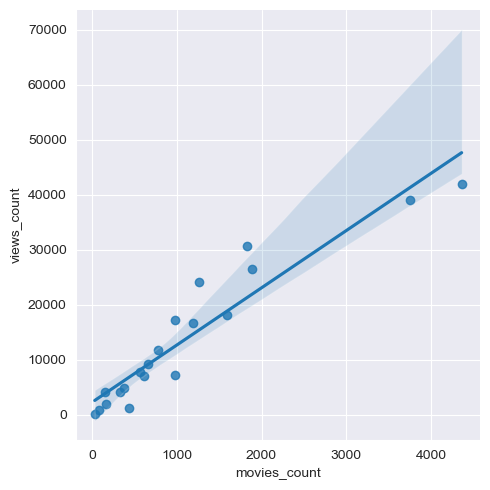

In [29]:
sns.lmplot(data=genres_df, x="movies_count", y="views_count")

It seems that the popularity of a movie category is proportional to the number of movies within that specific category. The question concerns the direction of causality. On one hand, it's rational to assume that the greater the number of movies within a category, the greater the number of views those movies will receive. On the other hand, the popularity of a movie category might prompt producers to release more movies in that specific category. Therefore, it's important to discern whether the popularity of a category leads to more movies being produced in that category, or if the abundance of movies in a category contributes to its popularity.

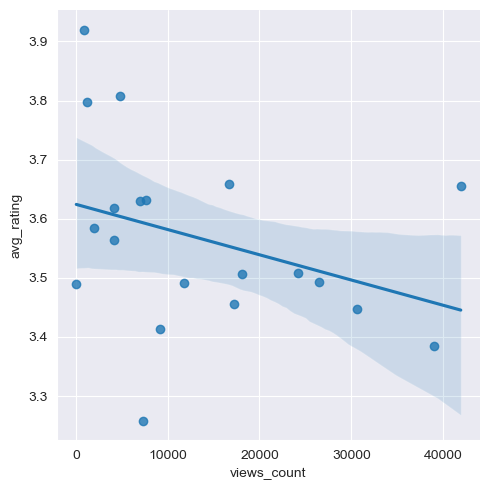

In [30]:
sns.lmplot(
    data=genres_df,
    x="views_count",
    y="avg_rating",
)

It seems that as the number of views is increasing the avg_rating of the genre is declining. Keep in mind thought that the markers are more scattered in this plot than the previous one leading to higher standard deviation for the model's estimator.

In [31]:
users_df

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,...,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),ratings_count,avg_rating
userId,,,,,,,,,,,,,,,,,,,,,
1,0.366379,0.125000,0.181034,0.357759,0.202586,0.112069,0.293103,0.387931,0.193966,0.237069,...,0.172414,0.094828,0.094828,0.000000,0.000000,0.030172,0.004310,0.0,0.085990,0.873276
2,0.103448,0.000000,0.000000,0.241379,0.000000,0.034483,0.586207,0.379310,0.344828,0.344828,...,0.137931,0.034483,0.000000,0.103448,0.137931,0.034483,0.000000,0.0,0.010749,0.789655
3,0.282051,0.102564,0.128205,0.230769,0.102564,0.128205,0.410256,0.358974,0.051282,0.179487,...,0.384615,0.128205,0.025641,0.000000,0.000000,0.000000,0.000000,0.0,0.014455,0.487179
4,0.134259,0.027778,0.046296,0.481481,0.087963,0.268519,0.555556,0.115741,0.125000,0.175926,...,0.055556,0.032407,0.074074,0.009259,0.004630,0.046296,0.018519,0.0,0.080059,0.711111
5,0.181818,0.136364,0.204545,0.340909,0.159091,0.250000,0.568182,0.204545,0.272727,0.204545,...,0.045455,0.068182,0.113636,0.000000,0.068182,0.045455,0.000000,0.0,0.016308,0.727273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.131839,0.037668,0.043946,0.377578,0.086996,0.318386,0.626009,0.135426,0.119283,0.178475,...,0.070852,0.058296,0.039462,0.004484,0.014350,0.015247,0.007175,0.0,0.413269,0.731480
607,0.240642,0.032086,0.101604,0.294118,0.112299,0.155080,0.438503,0.385027,0.144385,0.326203,...,0.192513,0.032086,0.026738,0.000000,0.005348,0.010695,0.000000,0.0,0.069311,0.757219
608,0.217810,0.066185,0.105897,0.427196,0.133574,0.127557,0.336943,0.333333,0.175692,0.311673,...,0.200963,0.022864,0.039711,0.007220,0.014440,0.013237,0.004813,0.0,0.308006,0.626835


In [32]:
# These are the libraries we used for the clustering
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import BisectingKMeans
from sklearn.cluster import OPTICS
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [33]:
scaler = StandardScaler()
users_ar = np.array(users_df)
scaler.fit(users_ar)
scaled_users_ar = scaler.transform(users_ar)

In [34]:
inertia_scores = []
silhouette_scores = []
for i in range(3, 30):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10, init="k-means++")
    kmeans.fit(scaled_users_ar)
    inertia_scores.append(kmeans.inertia_)
    score = metrics.silhouette_score(scaled_users_ar, kmeans.labels_)
    silhouette_scores.append(score)

Text(0, 0.5, 'WCSS')

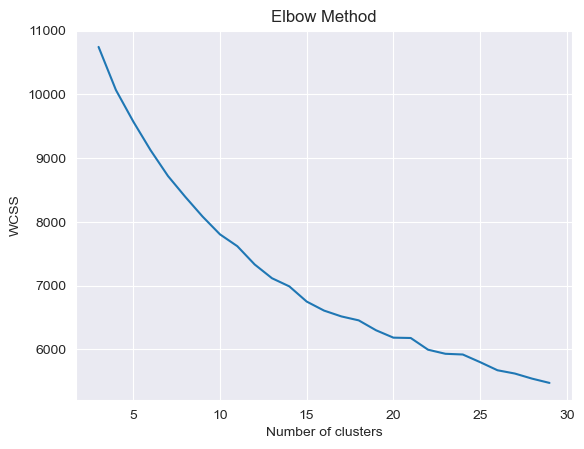

In [35]:
plt.plot(range(3, 30), inertia_scores)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")

Text(0.5, 1.0, 'Silhouette Score Method')

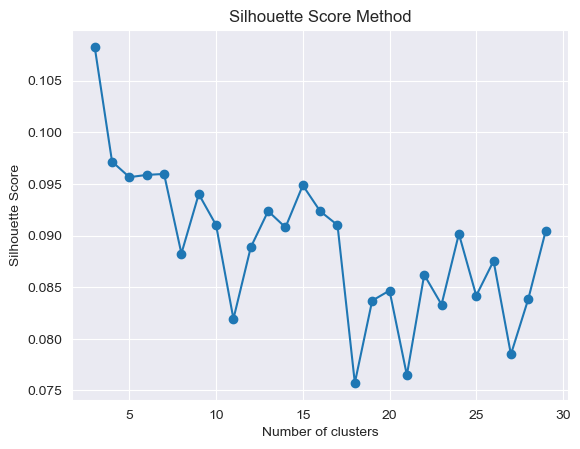

In [36]:
plt.plot(range(3, 30), silhouette_scores, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method")

Text(0.5, 1.0, 'Silhouette Method')

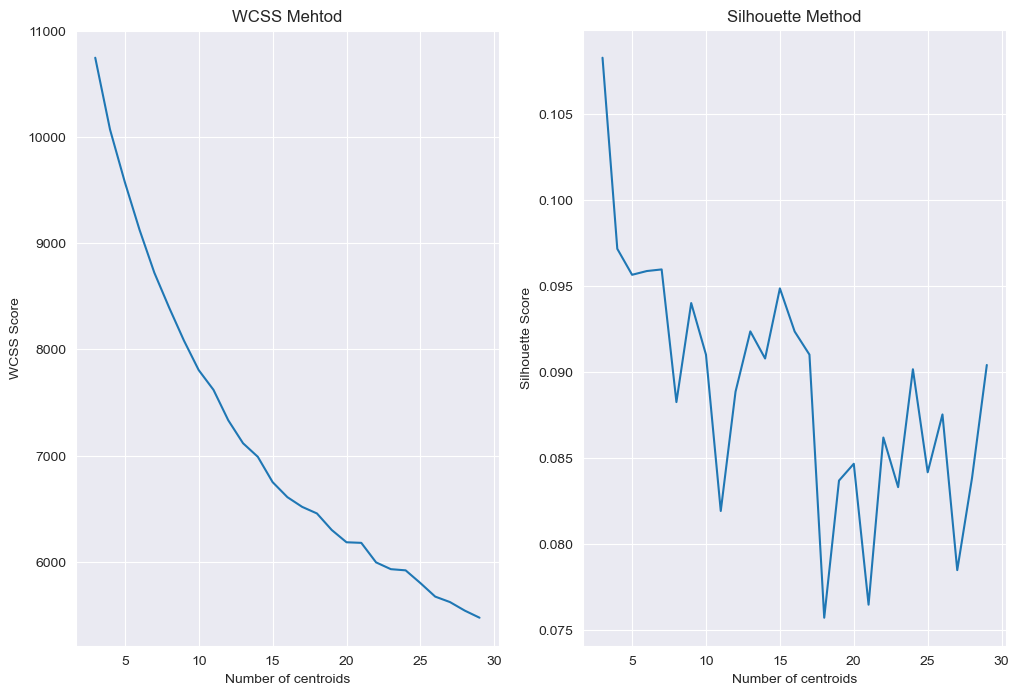

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
ax1.plot(range(3, 30), inertia_scores)
ax1.set_xlabel("Number of centroids")
ax1.set_ylabel("WCSS Score")
ax2.plot(range(3, 30), silhouette_scores)
ax2.set_xlabel("Number of centroids")
ax2.set_ylabel("Silhouette Score")
ax1.set_title("WCSS Mehtod")
ax2.set_title("Silhouette Method")

Let's plot our user types based on the two most popular movies genres.
Another crucial aspect I think is the how many movies each user has watched. This trait 
reflects how movie lover a user is.

Notice that all the highly movies lovers are categorized in the same category.

In [38]:
inertia_scores_bis = []
silhouette_scores_bis = []
for i in range(3, 30):
    kmeans_bis = BisectingKMeans(
        n_clusters=i, random_state=42, n_init=1, init="random", bisecting_strategy="biggest_inertia"
    )
    kmeans_bis.fit(scaled_users_ar)
    inertia_scores_bis.append(kmeans_bis.inertia_)
    score_bis = metrics.silhouette_score(scaled_users_ar, kmeans_bis.labels_)
    silhouette_scores_bis.append(score_bis)

Text(0.5, 1.0, 'Silhouette Method')

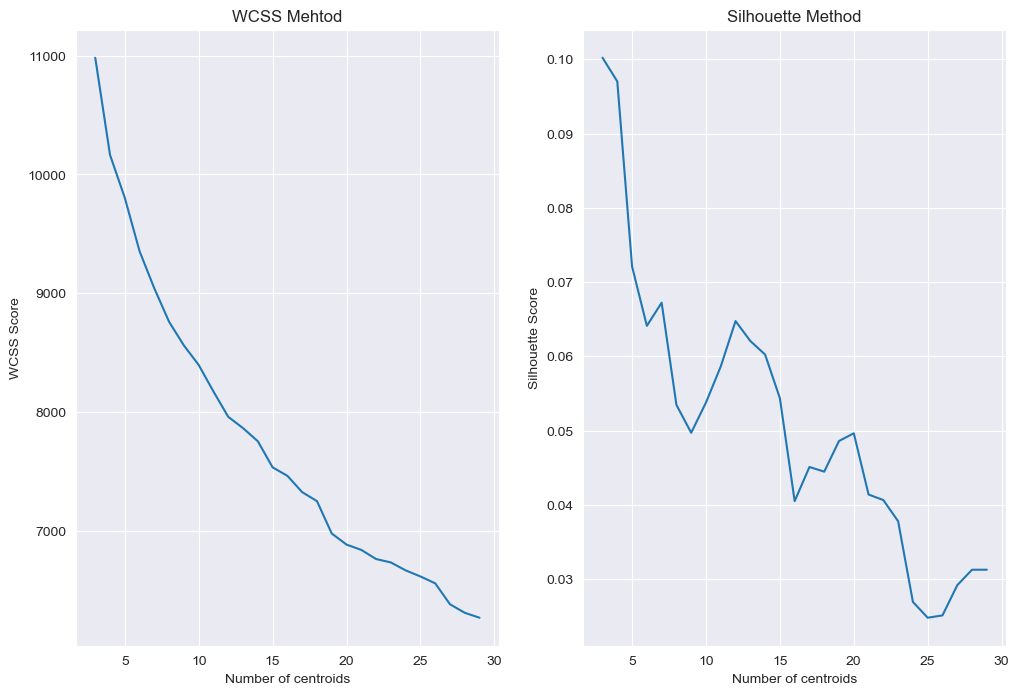

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
ax1.plot(range(3, 30), inertia_scores_bis)
ax1.set_xlabel("Number of centroids")
ax1.set_ylabel("WCSS Score")
ax2.plot(range(3, 30), silhouette_scores_bis)
ax2.set_xlabel("Number of centroids")
ax2.set_ylabel("Silhouette Score")
ax1.set_title("WCSS Mehtod")
ax2.set_title("Silhouette Method")

Based on the two implementations of KMeans clustering, we can notice that both algorithms perform pretty much the same. The optimal number of cluster seems to be the seven

In [40]:
kmeans = KMeans(n_clusters=15, init="k-means++", random_state=42, n_init=10)
users_ar = np.array(users_df)
kmeans.fit(users_ar)
users_df["user_type"] = kmeans.labels_

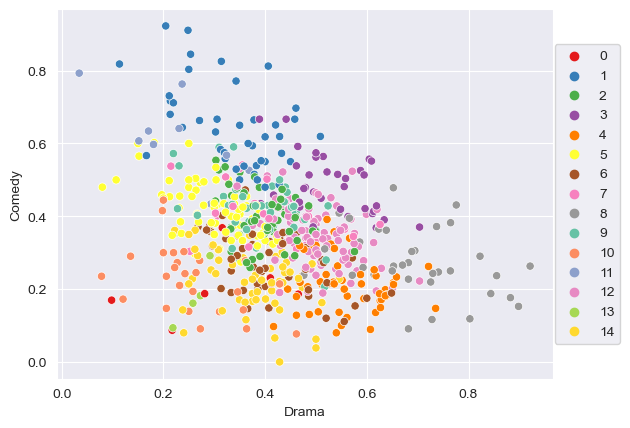

In [41]:
custom_palette = sns.color_palette("Set1", 9) + sns.color_palette("Set2", 6)
sns.scatterplot(data=users_df, x="Drama", y="Comedy", hue="user_type", palette=custom_palette)
plt.legend(loc="center right", bbox_to_anchor=(1.15, 0.5))

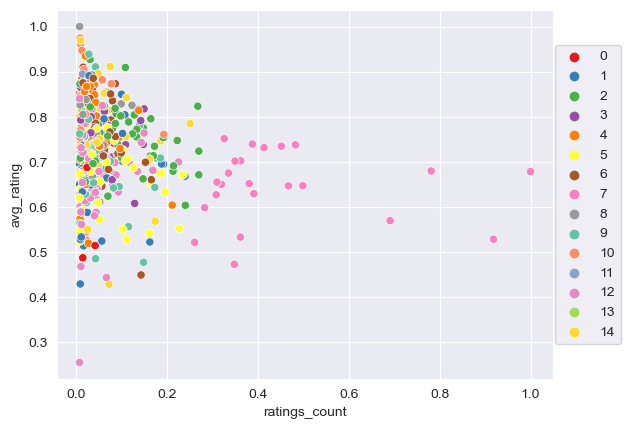

In [42]:
sns.scatterplot(data=users_df, x="ratings_count", y="avg_rating", hue="user_type", palette=custom_palette)
plt.legend(loc="center right", bbox_to_anchor=(1.15, 0.5))

In [43]:
pd.Series(kmeans.labels_).value_counts()

12    101
5      72
4      57
14     56
2      49
6      48
9      44
1      42
3      35
8      35
10     26
7      23
11      9
0       8
13      5
dtype: int64

## Clustering users based on the density

In [44]:
# Ended up using cosine because it gave the best results when it comes to similarity
optics = OPTICS(min_samples=5, xi=0.1, metric="cosine", algorithm="auto")

In [45]:
optics.fit(scaled_users_ar)

OPTICS(metric='cosine', xi=0.1)

Text(0, 0.5, 'Reachability Distance')

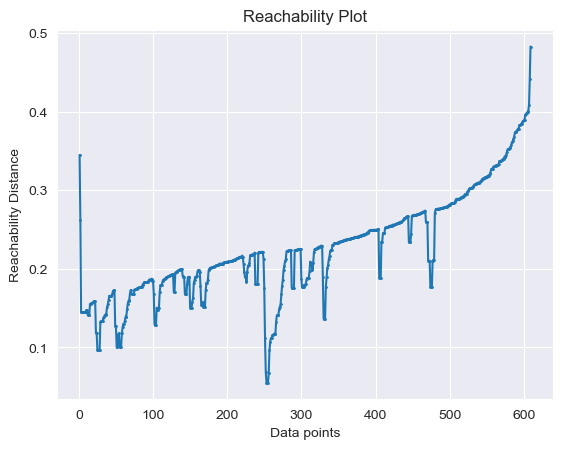

In [46]:
reachability = optics.reachability_[optics.ordering_]
plt.plot(reachability, marker="o", markersize=1)
plt.title("Reachability Plot")
plt.xlabel("Data points")
plt.ylabel("Reachability Distance")

In [47]:
pd.Series(optics.labels_).value_counts()

-1    562
 6     10
 1      8
 0      7
 4      7
 2      6
 3      5
 5      5
dtype: int64

Here we can see that from 610 users the 562 seems to be outliers. So the k-means model was picked over optics

Seems that the Density based algorithms can not cluster the data points. The main reason probably is the low density for users who have watched more than 500 movies.

DBSCAN (Density - Based - Spatial - Clustering - Application - Noise)

In [48]:
# This algorithm was used to find a good value for eps parameter of dbscan
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(scaled_users_ar)
distances, indices = knn.kneighbors(scaled_users_ar)
distance_of_fifth_nearest_neighboor = [distances[i][4] for i in range(0, len(distances))]
eps_par = np.mean(distance_of_fifth_nearest_neighboor)
print(eps_par)

0.2679014298373299


Text(0, 0.5, 'distance')

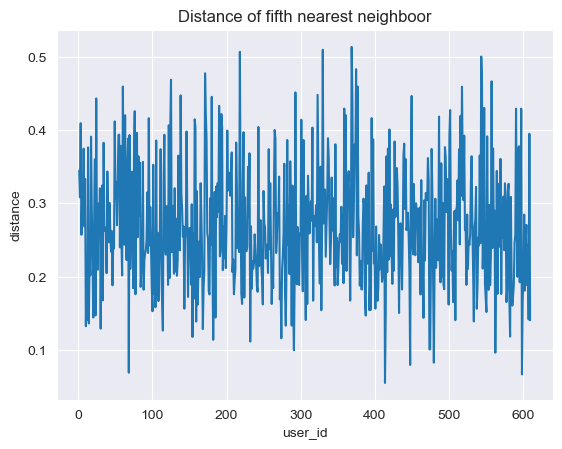

In [49]:
plt.plot(users_df.index, distance_of_fifth_nearest_neighboor)
plt.title("Distance of fifth nearest neighboor")
plt.xlabel("user_id")
plt.ylabel("distance")

In [50]:
dbscan = DBSCAN(eps=eps_par, metric="cosine", min_samples=5, algorithm="auto")

In [51]:
dbscan.fit(scaled_users_ar)

DBSCAN(eps=0.2679014298373299, metric='cosine')

In [52]:
set(dbscan.labels_)

{-1, 0, 1}

In [53]:
pd.Series(dbscan.labels_).value_counts()

 0    450
-1    147
 1     13
dtype: int64

Clustering based on density struggles to distinguish between different types of users due to the numerous combinations of movie preferences that often share one of two or three movie types. So the difference in preferences is not easy to be spotted.

## Data from IMDB

The data was collected from imdb using the links from the "links.csv". In the sent files you will find the code in the "imdb scraper.ipynb" file.

In [54]:
# Import and format the data
imdb = pd.read_csv("imdb_data.csv")
imdb.drop("Unnamed: 0", axis=1, inplace=True)
imdb = imdb[imdb["imdb_rating"] != "-"]

# Merge so we left with the ratings of only the movies that was collected
df = pd.merge(left=ratings, right=imdb, on="movieId")
df.set_index("movieId", inplace=True)

# Create a list that contains the 3 stars for each rating and then we drop the duplicates because some of the rating are on the same movie.
# In the end we are left with a list that as an index it has the movieID and as value the movie star that this movie id has (the same index appears up to 3 depends on the number of stars).
stars = df["imdb_stars"].str.split("|", expand=True).stack().reset_index(level=1, drop=True)
stars = pd.DataFrame(stars)
stars.reset_index(inplace=True)
stars.drop_duplicates(inplace=True)
stars.set_index("movieId", inplace=True)

# What we do next is to merge this list with the rating df only for the movies that was collected and find out the average rating of each movie star
df = pd.merge(left=stars, right=df, on="movieId").rename({0: "star"}, axis=1)
df["imdb_rating"] = df["imdb_rating"].apply(float)
star_avg_rating = df.groupby("star").mean(numeric_only=True)["imdb_rating"]

# Here we can see the top 5 and bottom 5 rated movie stars based on the movies that they partisipated and there rating
star_avg_rating.sort_values(ascending=False)

star
Jaromír Hanzlík       9.30000
Jonathan Fahn         9.30000
Carl Sagan            9.30000
Bob Gunton            9.21142
Oona Chaplin          9.10000
                       ...   
Stacii Jae Johnson    1.40000
Mia Tyler             1.40000
Dale Resteghini       1.40000
Darren Doane          1.30000
Bridgette Cameron     1.30000
Name: imdb_rating, Length: 11318, dtype: float64

In [55]:
# Set a function that takes this 3 ratings for each movie star of a movie and finds out the average of those 3 so we can see what rating this 3 movie star have when combined
# and we name this column avg_star_rating
def put_avg_rate_of_actors(row):
    stars = row["imdb_stars"].split("|")
    avg_rating = [float(star_avg_rating[star]) for star in stars]
    return np.mean(avg_rating)


df["avg_star_rating"] = df.apply(put_avg_rate_of_actors, axis=1)
df.drop("star", axis=1, inplace=True)
df.drop_duplicates(inplace=True)

In [56]:
# For the directors
directors = df["imdb_directors"].str.split("|", expand=True).stack().reset_index(level=1, drop=True)
directors = pd.DataFrame(directors)
directors.reset_index(inplace=True)
directors.drop_duplicates(inplace=True)
directors.set_index("movieId", inplace=True)

df = pd.merge(left=directors, right=df, on="movieId").rename({0: "director"}, axis=1)
df["imdb_rating"] = df["imdb_rating"].apply(float)
director_avg_rating = df.groupby("director").mean(numeric_only=True)["imdb_rating"]

# top 5 and bottom 5 directors
director_avg_rating.sort_values(ascending=False)

director
Steven Soter       9.300000
Ann Druyan         9.300000
Carl Sagan         9.300000
Carl Tibbetts      9.100000
Frank Darabont     9.006858
                     ...   
Clark L. Paylow    1.800000
James Nguyen       1.700000
Brett Kelly        1.500000
Dale Resteghini    1.400000
Darren Doane       1.300000
Name: imdb_rating, Length: 4443, dtype: float64

In [57]:
def put_avg_rate_of_directors(row):
    directors = row["imdb_directors"].split("|")
    avg_rating = [float(director_avg_rating[director]) for director in directors]
    return np.mean(avg_rating)


df["avg_director_rating"] = df.apply(put_avg_rate_of_directors, axis=1)
df.drop("director", axis=1, inplace=True)
df.drop_duplicates(inplace=True)

In [58]:
# For the writers
writers = df["imdb_writers"].str.split("|", expand=True).stack().reset_index(level=1, drop=True)
writers = pd.DataFrame(writers)
writers.reset_index(inplace=True)
writers.drop_duplicates(inplace=True)
writers.set_index("movieId", inplace=True)

df = pd.merge(left=writers, right=df, on="movieId").rename({0: "writer"}, axis=1)
df["imdb_rating"] = df["imdb_rating"].apply(float)
writer_avg_rating = df.groupby("writer").mean(numeric_only=True)["imdb_rating"]

# top 5 and bottom 5 writers
writer_avg_rating.sort_values(ascending=False)

writer
Robert Banks Stewart    9.300000
Charlie Brooker         9.100000
Thomas Keneally         9.000000
Reginald Rose           8.979310
Terry Nation            8.964286
                          ...   
James Nguyen            1.700000
David A. Lloyd          1.500000
Dale Resteghini         1.400000
Cheston Hervey          1.300000
Darren Doane            1.300000
Name: imdb_rating, Length: 10193, dtype: float64

In [59]:
def put_avg_rate_of_writers(row):
    writers = row["imdb_writers"].split("|")
    avg_rating = [float(writer_avg_rating[writer]) for writer in writers]
    return np.mean(avg_rating)


df["avg_writer_rating"] = df.apply(put_avg_rate_of_writers, axis=1)
df.drop("writer", axis=1, inplace=True)
df.drop_duplicates(inplace=True)

<Axes: >

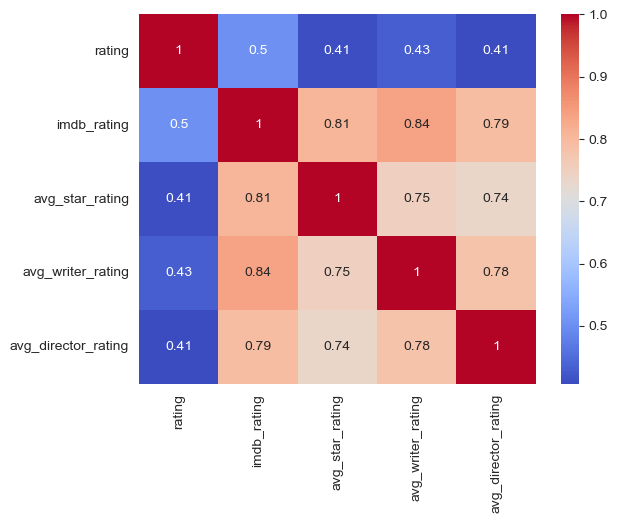

In [60]:
# Find out the correlation between rating predictors and the target value
corr_mat = (
    df[["rating", "imdb_rating", "avg_star_rating", "avg_writer_rating", "avg_director_rating"]]
    .groupby("movieId")
    .max()
    .corr()
)
sns.heatmap(corr_mat, cmap="coolwarm", annot=True)

In [61]:
user_type = users_df["user_type"]
# Because we have dropped some rows in which we had null values it is possible to more users on the user_type df
assert df["userId"].nunique() == len(user_type.index)
df = df.join(user_type, how="left", on="userId")

In [62]:
# Assistance on defining the functions below
# df[df['user_reviews'] == '-']
# df['imdb_popularity_step'].value_counts()
# df['imdb_popularity_current'].value_counts()

In [63]:
# When the data was collected from imdb the thousands has symbolized with a K and millions with M so format them accordingly
def convert_to_numeric(value):
    multipliers = {"K": 1000, "M": 1000000}
    if value[-1] in multipliers.keys():
        return float(value[:-1]) * multipliers[value[-1]]
    elif value != "-":
        return float(value)
    else:
        return 0


# Turn '-' to 0
def hyphen_converter(value):
    if value == "-":
        return 0
    elif "," in value:
        return float(value.replace(",", "."))
    else:
        return float(value)

In [64]:
# Apply each function to the correct column
df["user_reviews"] = df["user_reviews"].apply(convert_to_numeric)
df["imdb_raters"] = df["imdb_raters"].apply(convert_to_numeric)
df["imdb_popularity_step"] = df["imdb_popularity_step"].apply(hyphen_converter)
df["imdb_popularity_current"] = df["imdb_popularity_current"].apply(hyphen_converter)
df["critic_reviews"] = df["critic_reviews"].apply(convert_to_numeric)

In [65]:
# Drop unwanted columns
columns_to_drop = [
    "userId",
    "rating_timestamp",
    "rating_datetime",
    "title",
    "pop_status(g=green(up),r=red(down))",
    "imdb_directors",
    "imdb_writers",
    "imdb_stars",
]
df.drop(columns=columns_to_drop, axis=1, inplace=True)

In [66]:
# Create the dummies based on the user_type as before and drop the user_type column after
user_type_dummies = pd.get_dummies(df["user_type"], prefix="user_type", drop_first=True)
df = pd.concat([df, user_type_dummies], axis=1)
df.drop("user_type", axis=1, inplace=True)

# Model Training And Evaluation

## Base Random Forest model

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [93]:
# The features are some characteristic of the movie and user who have watched it.
X = df.drop("rating", axis=1)
y = df["rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [94]:
# We set this base model without parameter tuning to find a benchmark evaluation
RDregressor_bench = RandomForestRegressor(
    n_estimators=256, criterion="squared_error", max_features=0.8, max_depth=len(X.columns) + 10
)
RDregressor_bench.fit(X_train, y_train)

RandomForestRegressor(max_depth=54, max_features=0.8, n_estimators=256)

### Metrics on the test set VS Metrics on the train set

In [95]:
rd_pred_bech = RDregressor_bench.predict(X_test)
pred_on_train_set = RDregressor_bench.predict(X_train)

# Test set Metrics
print("Mean squared error: ", mean_squared_error(y_test, rd_pred_bech))
print("Mean absolute error: ", mean_absolute_error(y_test, rd_pred_bech), "\n")

# Train set metrics
print("Mean squared error: ", mean_squared_error(y_train, pred_on_train_set))
print("Mean absolute error: ", mean_absolute_error(y_train, pred_on_train_set), "\n")

Mean squared error:  0.7878200362763444
Mean absolute error:  0.6835804140763392 

Mean squared error:  0.11474532971312837
Mean absolute error:  0.2575535263340891 



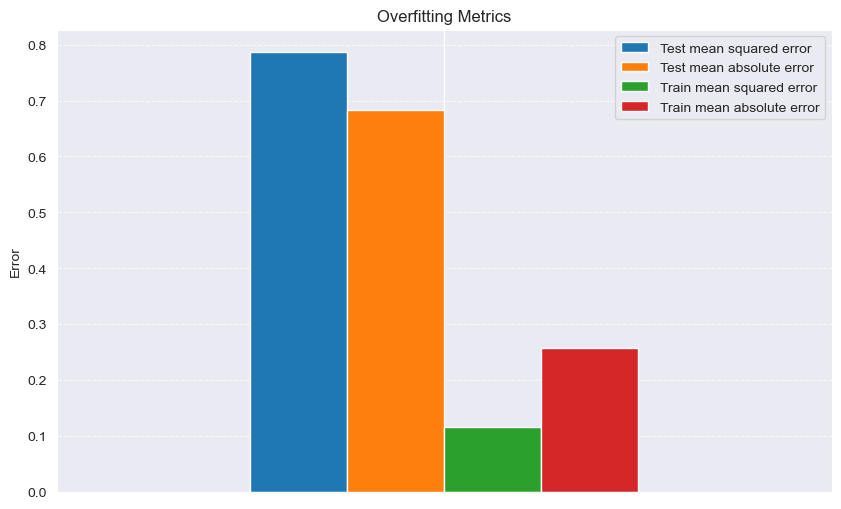

In [96]:
# Cecking for overfitting
overfitting = pd.DataFrame(
    {
        "Test mean squared error": [mean_squared_error(y_test, rd_pred_bech)],
        "Test mean absolute error": [mean_absolute_error(y_test, rd_pred_bech)],
        "Train mean squared error": [mean_squared_error(y_train, pred_on_train_set)],
        "Train mean absolute error": [mean_absolute_error(y_train, pred_on_train_set)],
    },
    index=[""],
)

overfitting.plot(kind="bar", figsize=(10, 6))
plt.title("Overfitting Metrics")
plt.ylabel("Error")
plt.grid(axis="y", linestyle="--", alpha=0.7)

At this point we can see a clear sign of overfitting. The model predict very well on the train set though it has poor performance on the training set. The reason is probably the parametres passed as arguments to the random forest estimator. To make it more clear below is an expanation of arguements in the model:
   1. max_features: This arguments define how many columns will be used in nodes where data are split. The more the features in the dataset the more complexity or flexibility we add allowing model to catch quirks of the dataset. On the other hand there is the trade-off of making our model biased and overfit to the train set ending up with poor performance on unseen data
   2. max_length :defines the depth of the tree. In case the value of this parametre is None the tree can grow as much as it needed in order to reduce the loss function at most. These trees are called bagged and they are very efficient in predicting previously seen data(train_set). Doing so, we add complexity again leading to a biased model with poor performance in unseen data.
   3. min_samples_split and min_samples_leaf: defines the minimum number of data points required for splitting internal nodes or leaves respectively. A large number can prevent overfitting but it can lead possibly to a oversimplified model uncapable to capture the relation between the features and the target variable

In [72]:
# Standpoint of a classification problem
rd_pred_rounded_bech = np.round(rd_pred_bech * 2) / 2
results = pd.DataFrame({"actual value": y_test, "predicted value": rd_pred_rounded_bech})
results["error"] = results["actual value"] - results["predicted value"]
accuracy = results["error"].value_counts()[0] / len(results)
print("Accuracy: ", accuracy)

Accuracy:  0.24733090130191773


## Resolving hyperparametrisation using GridSearch

There is not a 'one rule fit' on how to resolve hyperpamatrization and the optimal values of the parameters that will make the model being effective vary on the complexity of the dataset, the number of features and the number of data points.

As a rule of thumb, is to try different combinations of values passed in the parametres.
This is what we are going to do below using an already build-in functionality of scikit-learn.This idea of creating a 'grid' of parameters and just trying out all the possible combinations is called a Gridsearch. The CV stands for cross-validation which is the the number of folds in cross-validation to evaluate the performance of each combination of hyperparameters. Cross-validation is a technique used to assess the generalization performance of a model and to tune hyperparameters.

GridSearchCV takes a dictionary that describes the parameters that should be tried and a model to train. The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested. 

Note that this technique is computationaly - consuming and lazy and after excecuting once I will save the model with best parametres and comment out the corresponding block of code. 

In [73]:
"""from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor(n_estimators= 64)
param = {'max_features' : [0.4, 0.5 ,0.6, 0.7, 'sqrt'],
        'max_depth' : [20, 25, 30, 35],
        'min_samples_split' : [5, 15, 30, 50],
        'min_samples_leaf':[3, 5, 10, 20]}
grid_search = GridSearchCV(estimator= model, param_grid=param,
                           cv=5, scoring='r2',refit = True, n_jobs=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Score:", test_score)"""

'from sklearn.model_selection import GridSearchCV\nmodel = RandomForestRegressor(n_estimators= 64)\nparam = {\'max_features\' : [0.4, 0.5 ,0.6, 0.7, \'sqrt\'],\n        \'max_depth\' : [20, 25, 30, 35],\n        \'min_samples_split\' : [5, 15, 30, 50],\n        \'min_samples_leaf\':[3, 5, 10, 20]}\ngrid_search = GridSearchCV(estimator= model, param_grid=param,\n                           cv=5, scoring=\'r2\',refit = True, n_jobs=5)\ngrid_search.fit(X_train, y_train)\nbest_model = grid_search.best_estimator_\ntest_score = best_model.score(X_test, y_test)\nprint("Test Score:", test_score)'

In [74]:
# best_model.get_params

In [75]:
RDregressor = RandomForestRegressor(
    n_estimators=256,
    criterion="squared_error",
    max_features=0.7,
    min_samples_leaf=5,
    min_samples_split=30,
    max_depth=20,
)
RDregressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_leaf=5,
                      min_samples_split=30, n_estimators=256)

In [89]:
# Do exactly the same but now with the tuned parameters from rundom forrest
rd_pred = RDregressor.predict(X_test)
pred_on_train_set = RDregressor.predict(X_train)

# Test set Metrics
print("Test set Metrics")
print("Mean squared error: ", mean_squared_error(y_test, rd_pred))
print("Mean absolute error: ", mean_absolute_error(y_test, rd_pred), "\n")

# Train set metrics
print("Train set Metrics")
print("Mean squared error: ", mean_squared_error(y_train, pred_on_train_set))
print("Mean absolute error: ", mean_absolute_error(y_train, pred_on_train_set), "\n")

overfitting = pd.DataFrame(
    {
        "Test mean squared error": [mean_squared_error(y_test, rd_pred)],
        "Test mean absolute error": [mean_absolute_error(y_test, rd_pred)],
        "Train mean squared error": [mean_squared_error(y_train, pred_on_train_set)],
        "Train mean absolute error": [mean_absolute_error(y_train, pred_on_train_set)],
    },
    index=[""],
)

rd_pred_rounded = np.round(rd_pred * 2) / 2
results = pd.DataFrame({"actual value": y_test, "predicted value": rd_pred_rounded})
results["error"] = results["actual value"] - results["predicted value"]
accuracy = results["error"].value_counts()[0] / len(results)
print("Accuracy: ", accuracy)

Test set Metrics
Mean squared error:  0.7405637783855338
Mean absolute error:  0.6631099797067843 

Train set Metrics
Mean squared error:  0.5631549602952084
Mean absolute error:  0.5741419275784464 

Accuracy:  0.2520834030590047


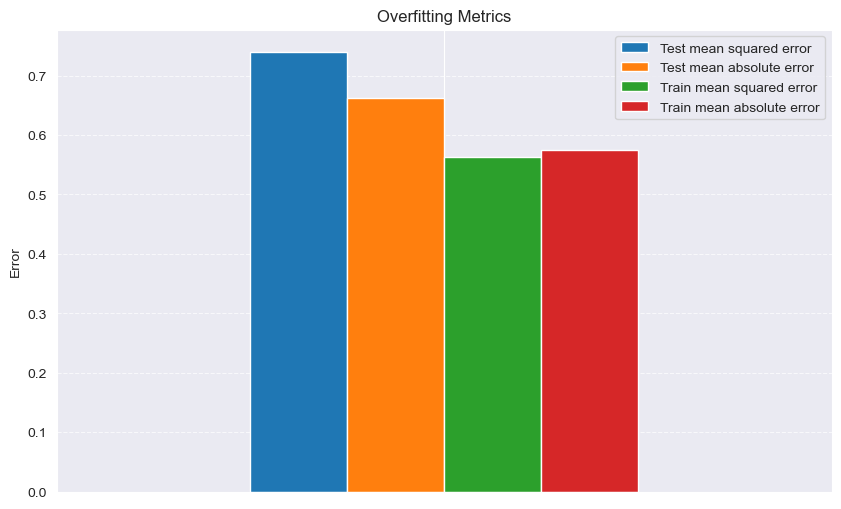

In [91]:
overfitting.plot(kind="bar", figsize=(10, 6))
plt.title("Overfitting Metrics")
plt.ylabel("Error")
plt.grid(axis="y", linestyle="--", alpha=0.7)

In [78]:
# In the RDregressor_model.pkl file the traing results are saved and this way you can load them
# import joblib
# joblib.dump(RDregressor, 'RDregressor_model.pkl')
# RDregressor = joblib.load('RDregressor_model.pkl')

 Metrics on Test set
Mean squared error:  0.7405637783855338 

Mean absolute error:  0.6631099797067843 

Metrics on Train set
Mean squared error:  0.5631549602952084 

Mean absolute error:  0.5741419275784464 

Accuracy:  0.2520834030590047


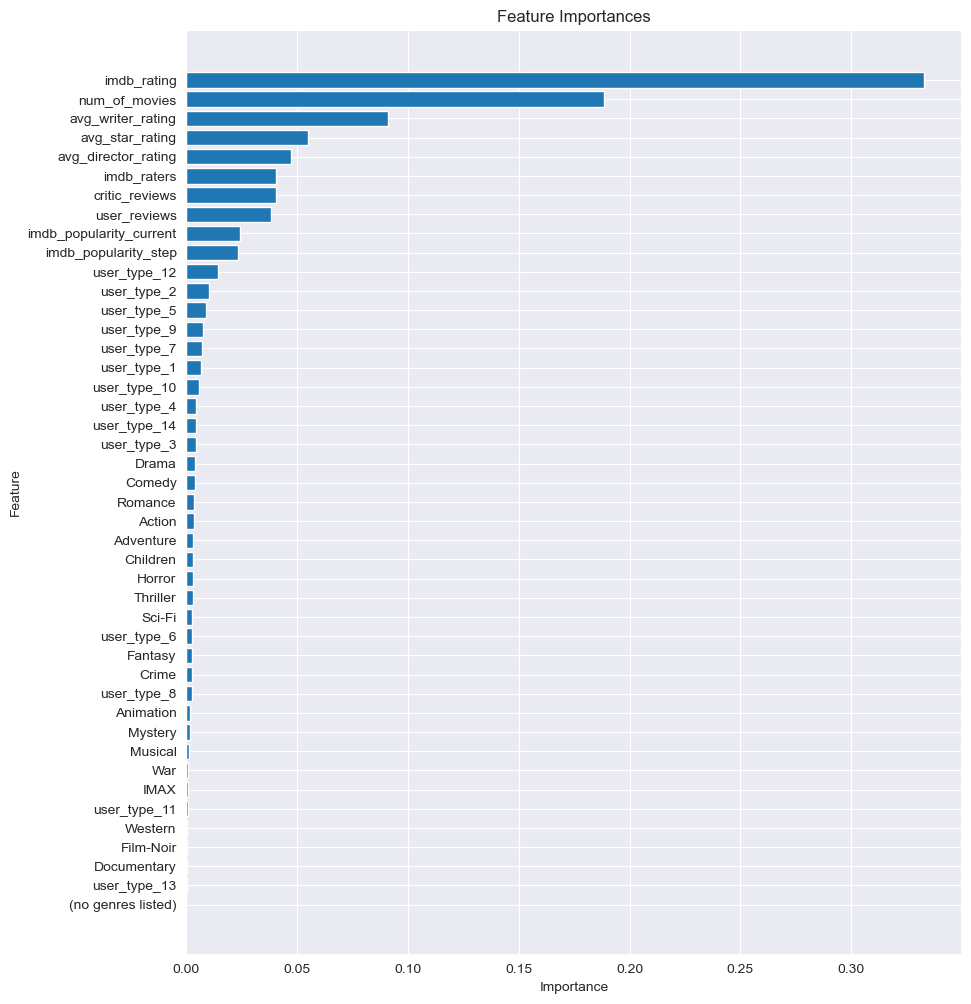

In [79]:
model_pred = RDregressor.predict(X_test)
model_pred_train_set = RDregressor.predict(X_train)
model_pred_rounded = np.round(model_pred * 2) / 2
# Test set Metrics
print(" Metrics on Test set")
print("Mean squared error: ", mean_squared_error(y_test, model_pred), "\n")
print("Mean absolute error: ", mean_absolute_error(y_test, model_pred), "\n")
# Train set metrics
print("Metrics on Train set")
print("Mean squared error: ", mean_squared_error(y_train, model_pred_train_set), "\n")
print("Mean absolute error: ", mean_absolute_error(y_train, model_pred_train_set), "\n")

# From the standpoint of a classification problem
RDregressor_results = pd.DataFrame({"actual value": y_test, "predicted value": model_pred_rounded})
RDregressor_results["error"] = RDregressor_results["actual value"] - RDregressor_results["predicted value"]
accuracy = RDregressor_results["error"].value_counts()[0] / len(RDregressor_results)
print("Accuracy: ", accuracy)

# Demonstrate the contibution of each feature
feature_importances = RDregressor.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Visualize the importance of each feuture in the data
plt.figure(figsize=(10, 12))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.gca().invert_yaxis()

## Linear Regression Model

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     453.5
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:11:14   Log-Likelihood:                -93216.
No. Observations:               69716   AIC:                         1.865e+05
Df Residuals:                   69671   BIC:                         1.869e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1279      0.075     -1.699      0.0

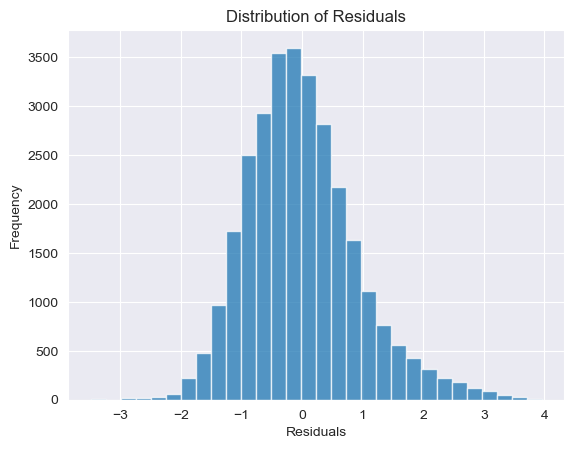

MAE: 0.7049096014214321
MSE: 0.8306519583191195
RMSE: 0.9114010962902774


In [80]:
# Convert pandas DataFrames to numpy arrays with float data type
X_train_np = X_train.astype(float).to_numpy()
y_train_np = y_train.astype(float).to_numpy()

# Add constant term to the feature matrix
X_train_const = sm.add_constant(X_train_np)

# Fit the ordinary least squares (OLS) model
model = sm.OLS(y_train_np, X_train_const).fit()

# Summary of the model
print(model.summary())

# Get predictions on the test set
X_test_const = sm.add_constant(X_test.astype(float).to_numpy())
lm_pred = model.predict(X_test_const)

# Calculate residuals
error_term = lm_pred - y_test

# Visualize the distribution of residuals to check for normality
plt.hist(error_term, bins=30, alpha=0.75)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

# Print evaluation metrics
print("MAE:", metrics.mean_absolute_error(y_test, lm_pred))
print("MSE:", metrics.mean_squared_error(y_test, lm_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lm_pred)))

In [81]:
# We see the columns of the X_train and we keep the ones based on p-value by checking the model.summary()
X_train.columns

Index(['num_of_movies', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western',
       'Film-Noir', '(no genres listed)', 'imdb_rating', 'imdb_raters',
       'imdb_popularity_step', 'imdb_popularity_current', 'user_reviews',
       'critic_reviews', 'avg_star_rating', 'avg_director_rating',
       'avg_writer_rating', 'user_type_1', 'user_type_2', 'user_type_3',
       'user_type_4', 'user_type_5', 'user_type_6', 'user_type_7',
       'user_type_8', 'user_type_9', 'user_type_10', 'user_type_11',
       'user_type_12', 'user_type_13', 'user_type_14'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     945.2
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:51:20   Log-Likelihood:                -93259.
No. Observations:               69716   AIC:                         1.866e+05
Df Residuals:                   69694   BIC:                         1.868e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1027      0.035     -2.902      0.0

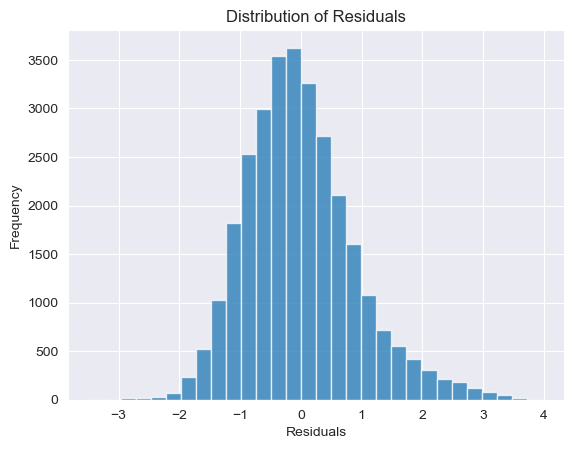

MAE: 0.7054447641687388
MSE: 0.8319902832990882
RMSE: 0.9121350137447242
R-Squared:  0.22263128410189725


In [98]:
# drop the column that based on the p-value are not statistical significant based on the model results
columns_to_keep = [
    "num_of_movies",
    "Children",
    "Romance",
    "Action",
    "Crime",
    "Horror",
    "Musical",
    "imdb_rating",
    "imdb_raters",
    "imdb_popularity_step",
    "imdb_popularity_current",
    "user_type_1",
    "user_type_2",
    "user_type_3",
    "user_type_4",
    "user_type_6",
    "user_type_8",
    "user_type_10",
    "user_type_12",
    "user_type_13",
    "user_type_14",
]
X_train_new = X_train[columns_to_keep]
X_test_new = X_test[columns_to_keep]

# Convert pandas DataFrames to numpy arrays with float data type
X_train_new_np = X_train_new.astype(float).to_numpy()
y_train_new_np = y_train.astype(float).to_numpy()

# Add constant term to the feature matrix
X_train_new_const = sm.add_constant(X_train_new_np)

# Fit the ordinary least squares (OLS) model
model_new = sm.OLS(y_train_new_np, X_train_new_const).fit()

# Summary of the model_new
print(model_new.summary())

# Get predictions on the test set
X_test_new_const = sm.add_constant(X_test_new.astype(float).to_numpy())
lm_pred_new = model_new.predict(X_test_new_const)

# Calculate residuals
error_term_new = lm_pred_new - y_test

# Visualize the distribution of residuals to check for normality
plt.hist(error_term_new, bins=30, alpha=0.75)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

# Print evaluation metrics
print("MAE:", metrics.mean_absolute_error(y_test, lm_pred_new))
print("MSE:", metrics.mean_squared_error(y_test, lm_pred_new))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lm_pred_new)))
print("R-Squared: ", r2_score(y_test, lm_pred_new))

In [83]:
# Here we see the effect fo each coefficient in the end results
summary_df = pd.DataFrame(
    model_new.params.astype(float), index=["constant"] + columns_to_keep, columns=["coefficients"]
)
summary_df["coefficients"] = summary_df["coefficients"].apply(lambda x: "{:.6f}".format(x))
summary_df

,coefficients
constant,-0.102681
num_of_movies,-0.000100
Children,-0.086735
Romance,0.039844
Action,-0.029464
Crime,0.035979
Horror,-0.089924
Musical,-0.040881
imdb_rating,0.509645
imdb_raters,-0.000000


## Resolving multicollinearity problem

Explained Variance Ratio: [0.10519376 0.07417663 0.06020046 0.05681468 0.05338466 0.05197138
 0.05137972 0.05063382 0.04964761 0.04934458]
Cumulative Explained Variance Ratio: [0.10519376 0.17937039 0.23957085 0.29638553 0.34977019 0.40174157
 0.45312129 0.50375511 0.55340272 0.60274729]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1249.
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:11:16   Log-Likelihood:                -96248.
No. Observations:               69716   AIC:                         1.925e+05
Df Residuals:                   69705   BIC:                         1.926e+05
Df Model:                          10                                         


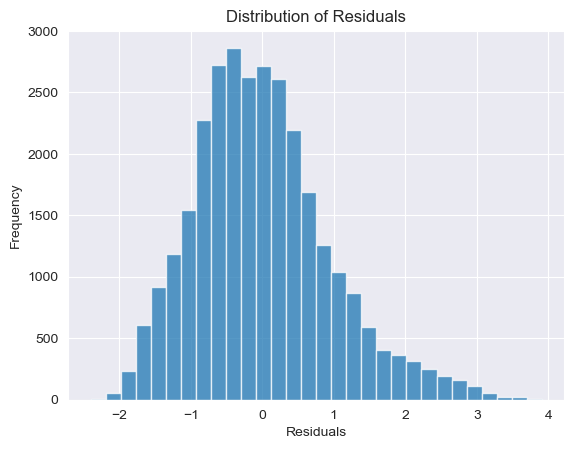

MAE: 0.7456586030843004
MSE: 0.9089563898812373
RMSE: 0.9533920441671607


In [84]:
from sklearn.decomposition import PCA

# Step 1: Scale the features (recommended for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)

# Step 2: Create and fit the PCA model
# Specify the number of components you want to keep (this can be a hyperparameter to tune)
num_components = 10  # For example, keep the first 2 principal components
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_scaled).astype(float)
X_test_pca = pca.transform(X_test_scaled).astype(float)

# Optional: Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Optional: Cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
print("Cumulative Explained Variance Ratio:", cumulative_explained_variance_ratio)

# Add constant term to the feature matrix
X_test_pca_const = sm.add_constant(X_train_pca)

# Fit the ordinary least squares (OLS) model
model_new_pca = sm.OLS(y_train_new_np, X_test_pca_const).fit()

# Summary of the model
print(model_new_pca.summary())

# Get predictions on the test set
X_test_pca_const = sm.add_constant(X_test_pca.astype(float))
lm_pred_pca = model_new_pca.predict(X_test_pca_const)

# Calculate residuals
error_term_pca = lm_pred_pca - y_test

# Visualize the distribution of residuals to check for normality
plt.hist(error_term_pca, bins=30, alpha=0.75)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

# Print evaluation metrics
print("MAE:", metrics.mean_absolute_error(y_test, lm_pred_pca))
print("MSE:", metrics.mean_squared_error(y_test, lm_pred_pca))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lm_pred_pca)))

The coefficients are not anymore interpretable because they are linear combination of the previous one

In [85]:
# From a classification problem standpoint
lm_pred_rounded = np.round(lm_pred_new * 2) / 2
lm_model_results = pd.DataFrame({"actual value": y_test, "predicted value": lm_pred_rounded})
lm_model_results["error"] = lm_model_results["actual value"] - lm_model_results["predicted value"]
accuracy = lm_model_results["error"].value_counts()[0] / len(lm_model_results)
print("Accuracy: ", accuracy)

Accuracy:  0.23237056126376385
